<a href="https://colab.research.google.com/github/KindoIssouf/MLClass2021/blob/main/Naivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KernelDensity
import io
from scipy import stats
import seaborn as sns
from scipy.stats import norm


In [ ]:

class NB:
    def fit(self, X, y):
        self.n_samples, self.n_features = X.shape  
        # P(y|X) = P(y)*P(X|y)
        self.classes = np.unique(y)

        # empty containers
        self.means = np.zeros((len(self.classes), self.n_features), dtype=float);
        self.variances = np.zeros((len(self.classes), self.n_features), dtype=float);
        self.class_prior = np.zeros(len(self.classes), dtype=float);

        for idx, cl in enumerate(self.classes):
            current_class = self.getCurentClass(X,y,cl)
            self.class_prior[idx] = len(current_class) / float(len(X))
            self.means[idx, :] = current_class.mean(axis=0)
            self.variances[idx, :] = current_class.std(axis=0)

    def predic(self, X):
         pred = [self.help_pred(x) for x in X]
         return pred

    def help_pred(self,x):
        posterieur = []
        for cl, current_class_prior in enumerate(self.class_prior):
            cl_c = np.sum(self.gaussian(x, self.means[cl], self.variances[cl]))
            posterieur.append(np.log(current_class_prior) + np.log( cl_c))
        return self.classes[np.argmax(posterieur)]

    # def gaussian(self, x, mean, variance):
    #     return 1/(np.sqrt(variance)* np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * variance**2))
    def gaussian(self,x, mean , sd):
        prob_density = norm(mean, sd).pdf(x)
        # prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
        return prob_density

    def getCurentClass(self,X,y, cl):
      r = []
      for idx in X.index.to_list():
          f = y.loc[idx]
          if f.iloc[0] == cl:
            r.append(X.loc[idx].to_numpy())
      return  pd.DataFrame(r)

    def accuracy(self,pred, y):
      top = 0
      for i in range(len(y)):
          if pred[i] == y[i]:
            top += 1
      return (top/len(y))

    def evaluate(self, pred, y_test):
        y_test = [x[0] for x in y_test]

        confusion_matrix = {"TP": 0, "FN": 0, "TN": 0, "FP": 0}
        for index in range(len(y_test)):
          if pred[index] == y_test[index] and pred[index]  == 1:
              confusion_matrix["TP"] += 1
          if pred[index] == y_test[index] and pred[index] == -1:
              confusion_matrix["TN"] += 1
          if pred[index] != y_test[index] and pred[index] == 1:
              confusion_matrix["FP"] += 1
          if pred[index] != y_test[index] and pred[index] == -1:
              confusion_matrix["FN"] += 1
        print("--------confusion matrix -----------------")
        tm = "\t +1\t\t -1\n +1\t TP: " + str(confusion_matrix["TP"]) + "\t\t FN: " + str(
            confusion_matrix["FN"]) + "\n -1\t FP: " + str(confusion_matrix["FP"]) + "\t\t TN: " + str(
            confusion_matrix["TN"])

        print(tm)
        print("\n Accuracy : ", self.accuracy(pred, y_test))


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving wdbc.data.mb (1).csv to wdbc.data.mb (1) (1).csv


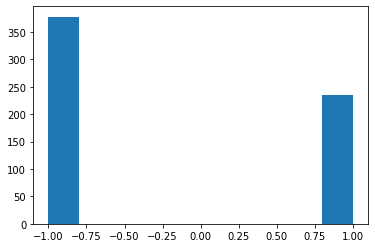

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['wdbc.data.mb (1).csv']),  names=[x for x in range(31)] )
# df = pd.read_csv("wdbc.data.mb.csv")
plt.hist(df.iloc[:,30])
plt.show()

# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()

    return df_std

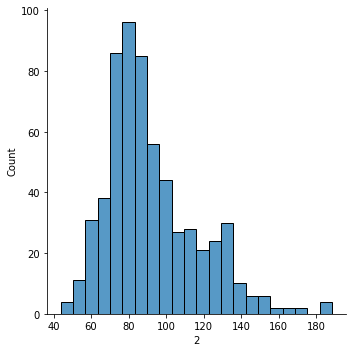

In [ ]:
#data distribution check
sns.displot(df, x=2)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503,0.1563,0.9567,1.094,8.205,0.008968,0.016460,0.01588,0.005917,0.02574,0.002582,8.964,21.96,57.26,242.2,0.1297,0.13570,0.06880,0.02564,0.3105,0.07409,-1
1,13.170,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.073400,0.2128,0.06777,0.2871,0.8937,1.897,24.250,0.006532,0.023360,0.02905,0.012150,0.01743,0.003643,15.670,27.95,102.80,759.4,0.1786,0.41660,0.50060,0.20880,0.3900,0.11790,1
2,12.050,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.027490,0.1675,0.06043,0.2636,0.7294,1.848,19.870,0.005488,0.014270,0.02322,0.005660,0.01428,0.002422,13.760,20.70,89.88,582.6,0.1494,0.21560,0.30500,0.06548,0.2747,0.08301,-1
3,13.490,22.30,86.91,561.0,0.08752,0.07698,0.04751,0.033840,0.1809,0.05718,0.2338,1.3530,1.735,20.200,0.004455,0.013820,0.02095,0.011840,0.01641,0.001956,15.150,31.82,99.00,698.8,0.1162,0.17110,0.22820,0.12820,0.2871,0.06917,-1
4,11.760,21.60,74.72,427.9,0.08637,0.04966,0.01657,0.011150,0.1495,0.05888,0.4062,1.2100,2.635,28.470,0.005857,0.009758,0.01168,0.007445,0.02406,0.001769,12.980,25.72,82.98,516.5,0.1085,0.08615,0.05523,0.03715,0.2433,0.06563,-1


In [ ]:
# with normalization
X=df.iloc[:, :30]
X= z_score(X)
y=df.iloc[:, 30:31]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
nb = NB()
nb.fit(X_train,y_train)
pred = nb.predic(X_test.to_numpy())
nb.evaluate(nb.predic(X_test.to_numpy()), y_test.to_numpy())


--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 53		 FN: 15
 -1	 FP: 3		 TN: 113

 Accuracy :  0.9021739130434783


In [ ]:
# K-fold
def k_fold_val( df,k=5):
  df = df.sample(n=len(df), random_state=1234)
  training_ratio = 1/k * len(df)
  begin = 0
  end = int(training_ratio)
  accuracies = np.zeros(k,dtype = float)
  for i in range(k):
    nb = NB()
    traning = df.iloc[end: , : ]
    if begin <0:
      traning.append(df.iloc[ :begin, : ])
    testing = df.iloc[begin:end, : ]
    begin += int(training_ratio)
    end += int(training_ratio)
    X_train = traning.iloc[ :, :len(df.columns)-1]
    y_train = traning.iloc[ :, len(df.columns)-1:len(df.columns)]
    X_test = testing.iloc[ :, :len(df.columns)-1]
    y_test = testing.iloc[ :,  len(df.columns)-1:len(df.columns)]
    X_train = z_score(X_train)
    X_test = z_score(X_test)
    nb.fit(X_train,y_train)
    pred = nb.predic(X_test.to_numpy())
    nb.evaluate(pred ,y_test.to_numpy())
    accuracies[i] = nb.accuracy(pred, y_test.to_numpy())
  # print(accuracies)

  print("\n----5-fold: Average Accuracy -----------------")
  print("\n Average Accuracy: ",accuracies.mean())
  print("\n-----------------------------------------")

k_fold_val(df)
# df = df.sample(n=len(df), random_state=123)
# k_fold_val()
# df = df.sample(n=len(df), random_state=12)
# k_fold_val()

--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 36		 FN: 10
 -1	 FP: 3		 TN: 73

 Accuracy :  0.8934426229508197
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 40		 FN: 7
 -1	 FP: 1		 TN: 74

 Accuracy :  0.9344262295081968
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 36		 FN: 10
 -1	 FP: 1		 TN: 75

 Accuracy :  0.9098360655737705
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 38		 FN: 8
 -1	 FP: 2		 TN: 74

 Accuracy :  0.9180327868852459
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 0		 FN: 48
 -1	 FP: 0		 TN: 74

 Accuracy :  0.6065573770491803

----5-fold: Average Accuracy -----------------

 Average Accuracy:  0.8524590163934427

-----------------------------------------


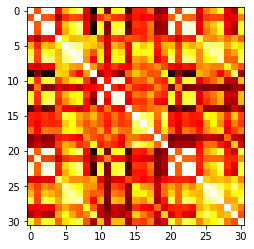

In [ ]:
corr = df.corr(method='pearson')
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
# dropping highly correlated features
df_cleaned = df
for i in range(len(corr)):
  for j in range(len(corr)):
    if corr[i][j] <=  .8   :
      continue
    else:
      if i != j and j in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=[j] , axis=1)

print(df_cleaned.head())


        4       8        9       11  ...       18      24      28  30
0  0.08600  0.1769  0.06503  0.9567  ...  0.02574  0.1297  0.3105  -1
1  0.11580  0.2128  0.06777  0.8937  ...  0.01743  0.1786  0.3900   1
2  0.10310  0.1675  0.06043  0.7294  ...  0.01428  0.1494  0.2747  -1
3  0.08752  0.1809  0.05718  1.3530  ...  0.01641  0.1162  0.2871  -1
4  0.08637  0.1495  0.05888  1.2100  ...  0.02406  0.1085  0.2433  -1

[5 rows x 10 columns]


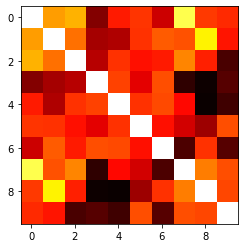

In [ ]:
corr = df_cleaned.corr(method='pearson')
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
X=df_cleaned.iloc[:, :len(df_cleaned.columns) - 1 ]
X= z_score(X)
y=df_cleaned.iloc[:, -1]
y = y.to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
nb = NB()
nb.fit(X_train,y_train)
pred = nb.predic(X_test.to_numpy())
k_fold_val(df_cleaned)
# print(nb.evaluate(pred,y_test.to_numpy()))

--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 2		 FN: 44
 -1	 FP: 3		 TN: 73

 Accuracy :  0.6147540983606558
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 6		 FN: 41
 -1	 FP: 1		 TN: 74

 Accuracy :  0.6557377049180327
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 10		 FN: 36
 -1	 FP: 1		 TN: 75

 Accuracy :  0.6967213114754098
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 1		 FN: 45
 -1	 FP: 0		 TN: 76

 Accuracy :  0.6311475409836066
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 0		 FN: 48
 -1	 FP: 0		 TN: 74

 Accuracy :  0.6065573770491803

----5-fold: Average Accuracy -----------------

 Average Accuracy:  0.6409836065573771

-----------------------------------------



        0      1       2       3   ...       27      28       29  30
540  16.13  20.68  108.10   798.8  ...  0.20730  0.3706  0.11420   1
317  16.50  18.29  106.60   838.1  ...  0.09123  0.2394  0.06469  -1
596  13.65  13.16   87.88   568.9  ...  0.08056  0.2380  0.08718  -1
164  20.58  22.14  134.70  1290.0  ...  0.19200  0.2909  0.05865   1
746  20.13  28.25  131.20  1261.0  ...  0.16280  0.2572  0.06637   1

[5 rows x 31 columns]


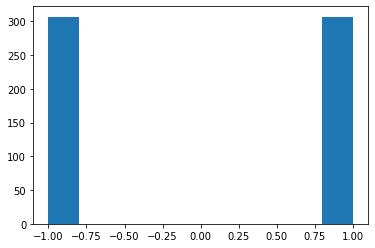

In [ ]:
neg =  df[df[30] == -1]
pos =  df[df[30] == 1]
print()
p = pos.sample((len(neg)-len(pos)), random_state=1234)
df_long = df.append(p,  ignore_index=True)
df_long = df_long.sample(n=len(df), random_state=1234)
print(df_long.tail())
plt.hist(df_long.iloc[:,30])
plt.show()

In [ ]:
X=df_long.iloc[:, :len(df_long.columns) - 1 ]
X= z_score(X)
y=df_long.iloc[:, -1]
y = y.to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
nb = NB()
nb.fit(X_train,y_train)
pred = nb.predic(X_test.to_numpy())
# print(nb.evaluate(pred,y_test.to_numpy()))
k_fold_val(df_long)


--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 54		 FN: 0
 -1	 FP: 52		 TN: 16

 Accuracy :  0.5737704918032787
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 61		 FN: 0
 -1	 FP: 34		 TN: 27

 Accuracy :  0.7213114754098361
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 59		 FN: 0
 -1	 FP: 58		 TN: 5

 Accuracy :  0.5245901639344263
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 63		 FN: 0
 -1	 FP: 58		 TN: 1

 Accuracy :  0.5245901639344263
--------confusion matrix -----------------
	 +1		 -1
 +1	 TP: 68		 FN: 0
 -1	 FP: 54		 TN: 0

 Accuracy :  0.5573770491803278

----5-fold: Average Accuracy -----------------

 Average Accuracy:  0.5803278688524591

-----------------------------------------
